Connected to .venv (Python 3.12.3)

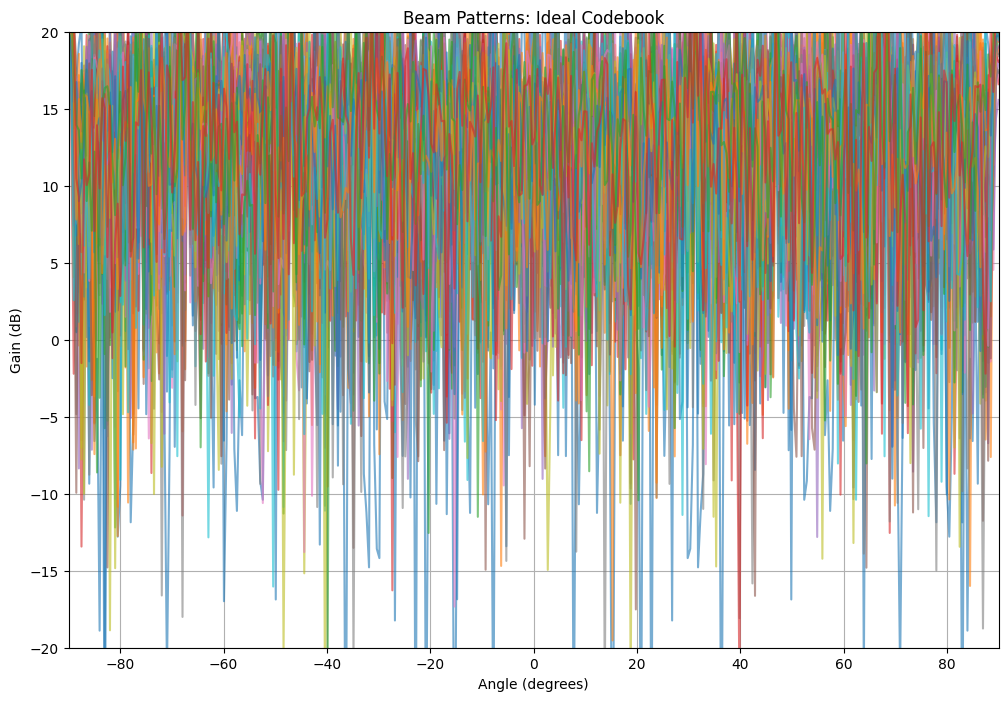

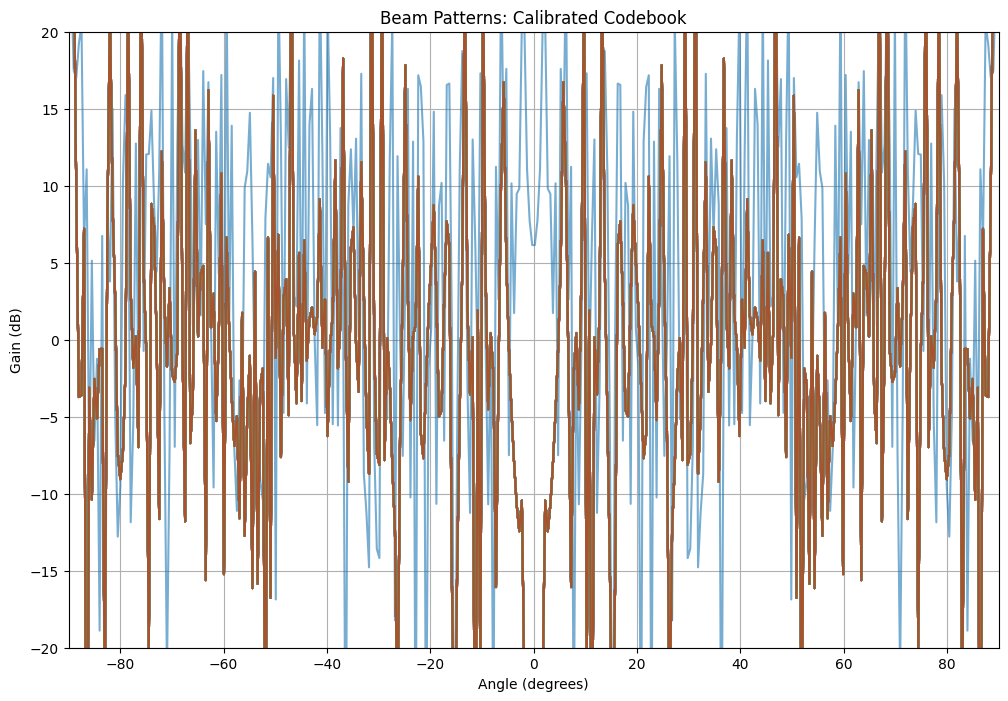

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load beam codebook data
def load_beam_codebook(file_path):
    df = pd.read_csv(file_path, header=None)
    beam_weights = df.values.astype(str)  # Hex strings
    return beam_weights

# Convert hex to phase shifts (0x00 to 0x3F -> 0 to 2π radians)
def hex_to_phase(hex_str):
    return (int(hex_str, 16) / 0x3F) * 2 * np.pi  # Normalize to [0, 2π]

# Simulate beam pattern for a ULA
def simulate_beam_pattern(weights, freq=60e9, element_spacing=0.5):
    wavelength = 3e8 / freq
    theta = np.linspace(-np.pi/2, np.pi/2, 360)  # Angle range
    num_elements = len(weights)
    
    # Array response vector
    array_response = np.exp(
        1j * 2 * np.pi * element_spacing * np.sin(theta)[:, np.newaxis] * 
        np.arange(num_elements)[np.newaxis, :] / wavelength
    )
    
    # Apply phase weights
    weighted_response = array_response * np.exp(1j * np.array(weights))
    beam_pattern = np.abs(np.sum(weighted_response, axis=1))  # Sum across elements
    
    return theta, beam_pattern

# Plot beam patterns for all beams
def plot_all_beams(beam_weights, title):
    plt.figure(figsize=(12, 8))
    for i, beam in enumerate(beam_weights[:64]):  # Plot first 64 beams
        phase_weights = [hex_to_phase(val) for val in beam]
        theta, pattern = simulate_beam_pattern(phase_weights)
        plt.plot(np.degrees(theta), 20 * np.log10(pattern + 1e-10), alpha=0.6)
    
    plt.title(f"Beam Patterns: {title}")
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Gain (dB)")
    plt.grid(True)
    plt.xlim(-90, 90)
    plt.ylim(-20, 20)
    plt.show()

# Load and visualize
beam_weights_ideal = load_beam_codebook("Antenna_beambook_ideal.csv")
beam_weights_measured = load_beam_codebook("Antenna_beambook.csv")

plot_all_beams(beam_weights_ideal, "Ideal Codebook")
plot_all_beams(beam_weights_measured, "Calibrated Codebook")

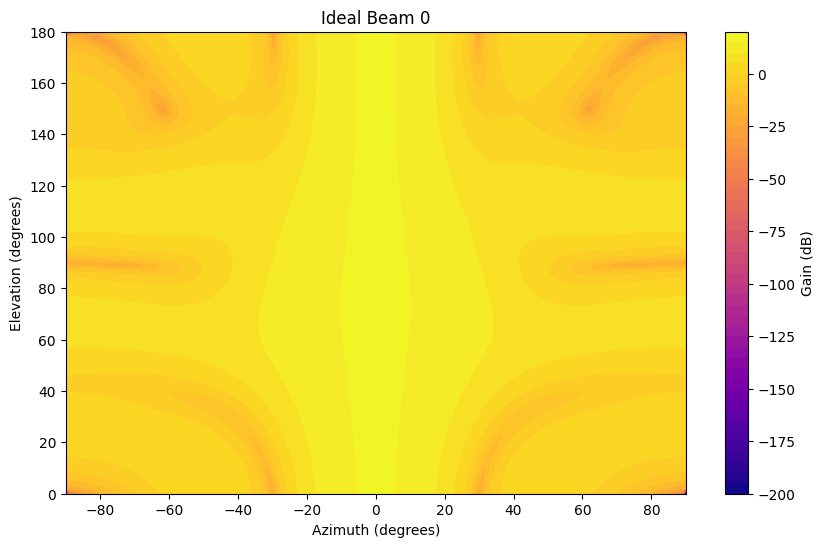

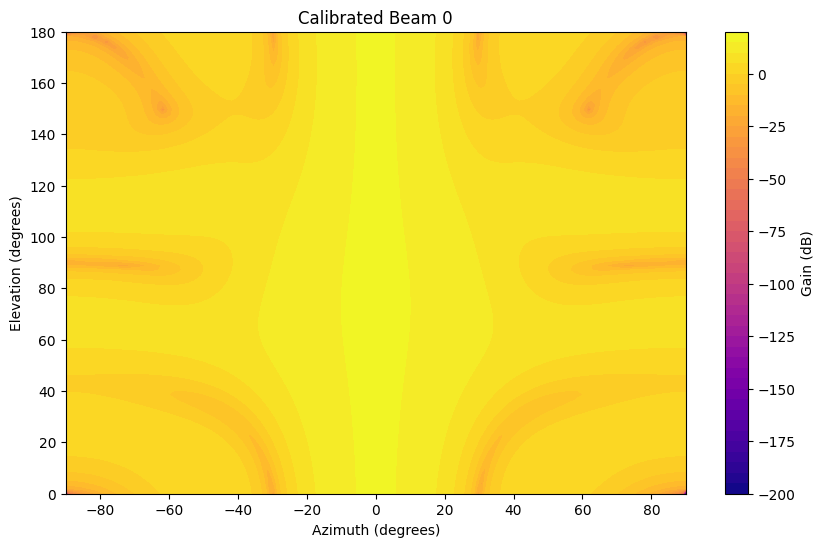

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm

# Load data (first 16 columns = TX weights)
def load_beam_codebook(file_path):
    df = pd.read_csv(file_path, header=None)
    return df.iloc[:, :16].values.astype(str)  # Only use first 16 columns

# Convert hex to amplitude (0x00 to 0x3F -> 0 to 1)
def hex_to_amplitude(hex_str):
    return int(hex_str, 16) / 0x3F  # Normalize to [0, 1]

# Simulate beam pattern for a 4x4 planar array
def simulate_beam_pattern_2d(weights, freq=60e9):
    wavelength = 3e8 / freq
    spacing = wavelength / 2
    theta = np.linspace(-np.pi/2, np.pi/2, 180)  # Azimuth
    phi = np.linspace(0, np.pi, 90)              # Elevation
    theta_grid, phi_grid = np.meshgrid(theta, phi)
    
    # 4x4 array positions
    x = np.arange(4) * spacing
    y = np.arange(4) * spacing
    xx, yy = np.meshgrid(x, y)
    positions = np.vstack([xx.ravel(), yy.ravel()]).T
    
    # Reshape weights to 4x4 (ensure 16 elements)
    assert len(weights) == 16, f"Expected 16 weights, got {len(weights)}"
    weights_2d = np.reshape([hex_to_amplitude(w) for w in weights], (4, 4))
    
    # Array response
    beam_pattern = np.zeros_like(theta_grid)
    for i, t in enumerate(theta):
        for j, p in enumerate(phi):
            wave_vector = 2 * np.pi * np.array([np.sin(t) * np.cos(p), 
                                              np.sin(t) * np.sin(p)]) / wavelength
            phase_delays = np.exp(1j * (positions @ wave_vector))
            weighted_response = phase_delays * weights_2d.ravel()
            beam_pattern[j, i] = np.abs(np.sum(weighted_response))
    
    return np.degrees(theta_grid), np.degrees(phi_grid), beam_pattern

# Plot single beam pattern
def plot_beam_2d(theta, phi, pattern, title):
    plt.figure(figsize=(10, 6))
    plt.contourf(theta, phi, 20 * np.log10(pattern + 1e-10), levels=50, cmap=cm.plasma)
    plt.colorbar(label="Gain (dB)")
    plt.title(title)
    plt.xlabel("Azimuth (degrees)")
    plt.ylabel("Elevation (degrees)")
    plt.show()

# Load data (first 16 columns = TX weights)
beam_weights_ideal = load_beam_codebook("Antenna_beambook_ideal.csv")
beam_weights_calib = load_beam_codebook("Antenna_beambook.csv")

# Plot first beam
beam_idx = 0  # Change to inspect other beams
theta, phi, pattern_ideal = simulate_beam_pattern_2d(beam_weights_ideal[beam_idx])
plot_beam_2d(theta, phi, pattern_ideal, f"Ideal Beam {beam_idx}")

theta, phi, pattern_calib = simulate_beam_pattern_2d(beam_weights_calib[beam_idx])
plot_beam_2d(theta, phi, pattern_calib, f"Calibrated Beam {beam_idx}")

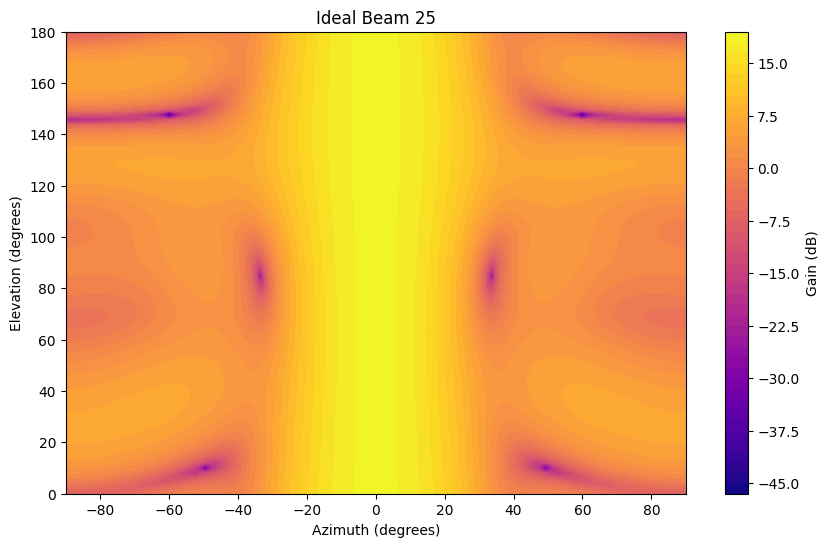

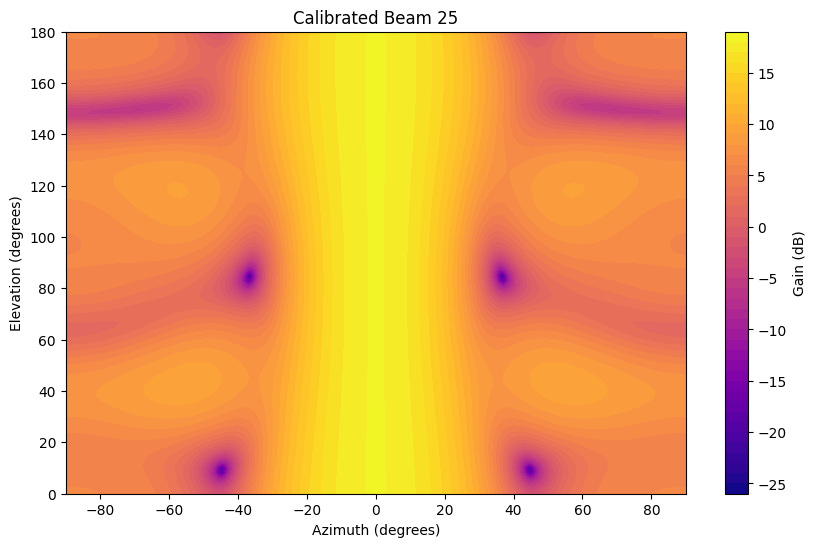

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm

# Load data (first 16 columns = TX weights)
def load_beam_codebook(file_path):
    df = pd.read_csv(file_path, header=None)
    return df.iloc[:, :16].values.astype(str)  # Only use first 16 columns

# Convert hex to amplitude (0x00 to 0x3F -> 0 to 1)
def hex_to_amplitude(hex_str):
    return int(hex_str, 16) / 0x3F  # Normalize to [0, 1]

# Simulate beam pattern for a 4x4 planar array
def simulate_beam_pattern_2d(weights, freq=60e9):
    wavelength = 3e8 / freq
    spacing = wavelength / 2
    theta = np.linspace(-np.pi/2, np.pi/2, 180)  # Azimuth
    phi = np.linspace(0, np.pi, 90)              # Elevation
    theta_grid, phi_grid = np.meshgrid(theta, phi)
    
    # 4x4 array positions
    x = np.arange(4) * spacing
    y = np.arange(4) * spacing
    xx, yy = np.meshgrid(x, y)
    positions = np.vstack([xx.ravel(), yy.ravel()]).T
    
    # Reshape weights to 4x4 (ensure 16 elements)
    assert len(weights) == 16, f"Expected 16 weights, got {len(weights)}"
    weights_2d = np.reshape([hex_to_amplitude(w) for w in weights], (4, 4))
    
    # Array response
    beam_pattern = np.zeros_like(theta_grid)
    for i, t in enumerate(theta):
        for j, p in enumerate(phi):
            wave_vector = 2 * np.pi * np.array([np.sin(t) * np.cos(p), 
                                              np.sin(t) * np.sin(p)]) / wavelength
            phase_delays = np.exp(1j * (positions @ wave_vector))
            weighted_response = phase_delays * weights_2d.ravel()
            beam_pattern[j, i] = np.abs(np.sum(weighted_response))
    
    return np.degrees(theta_grid), np.degrees(phi_grid), beam_pattern

# Plot single beam pattern
def plot_beam_2d(theta, phi, pattern, title):
    plt.figure(figsize=(10, 6))
    plt.contourf(theta, phi, 20 * np.log10(pattern + 1e-10), levels=50, cmap=cm.plasma)
    plt.colorbar(label="Gain (dB)")
    plt.title(title)
    plt.xlabel("Azimuth (degrees)")
    plt.ylabel("Elevation (degrees)")
    plt.show()

# Load data (first 16 columns = TX weights)
beam_weights_ideal = load_beam_codebook("Antenna_beambook_ideal.csv")
beam_weights_calib = load_beam_codebook("Antenna_beambook.csv")

# Plot first beam
beam_idx = 25  # Change to inspect other beams
theta, phi, pattern_ideal = simulate_beam_pattern_2d(beam_weights_ideal[beam_idx])
plot_beam_2d(theta, phi, pattern_ideal, f"Ideal Beam {beam_idx}")

theta, phi, pattern_calib = simulate_beam_pattern_2d(beam_weights_calib[beam_idx])
plot_beam_2d(theta, phi, pattern_calib, f"Calibrated Beam {beam_idx}")

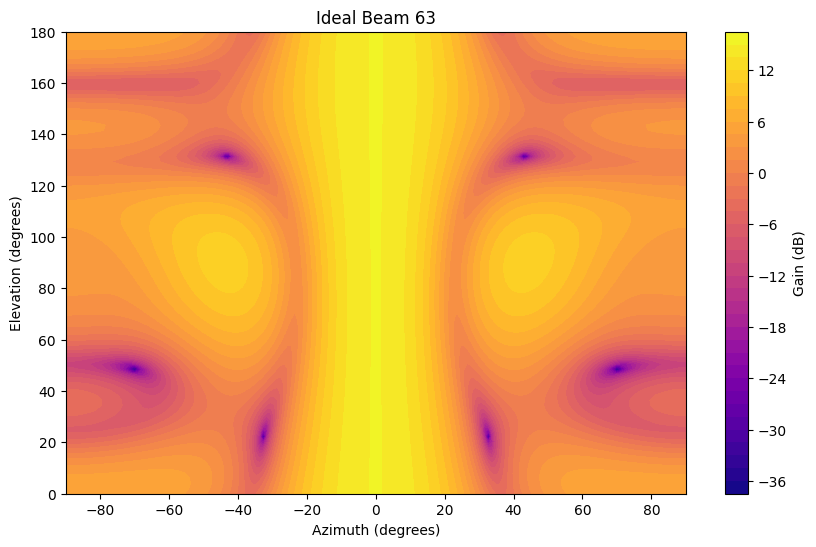

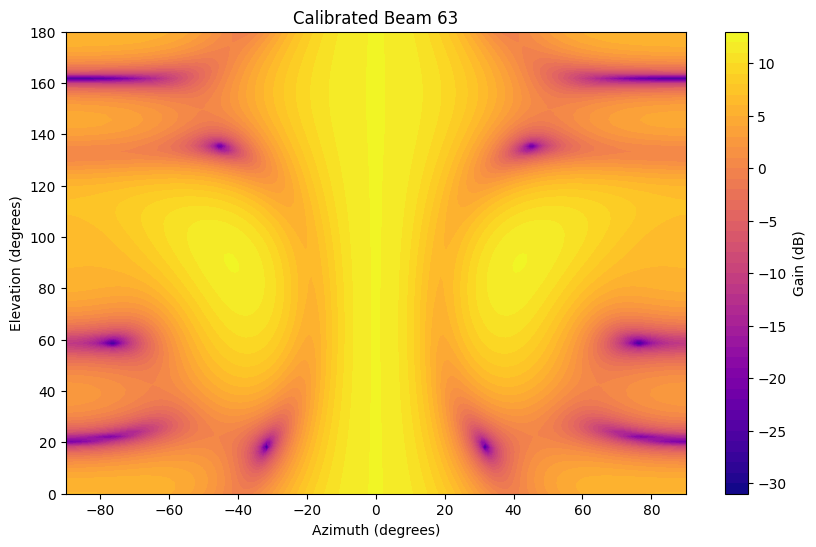

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm

# Load data (first 16 columns = TX weights)
def load_beam_codebook(file_path):
    df = pd.read_csv(file_path, header=None)
    return df.iloc[:, :16].values.astype(str)  # Only use first 16 columns

# Convert hex to amplitude (0x00 to 0x3F -> 0 to 1)
def hex_to_amplitude(hex_str):
    return int(hex_str, 16) / 0x3F  # Normalize to [0, 1]

# Simulate beam pattern for a 4x4 planar array
def simulate_beam_pattern_2d(weights, freq=60e9):
    wavelength = 3e8 / freq
    spacing = wavelength / 2
    theta = np.linspace(-np.pi/2, np.pi/2, 180)  # Azimuth
    phi = np.linspace(0, np.pi, 90)              # Elevation
    theta_grid, phi_grid = np.meshgrid(theta, phi)
    
    # 4x4 array positions
    x = np.arange(4) * spacing
    y = np.arange(4) * spacing
    xx, yy = np.meshgrid(x, y)
    positions = np.vstack([xx.ravel(), yy.ravel()]).T
    
    # Reshape weights to 4x4 (ensure 16 elements)
    assert len(weights) == 16, f"Expected 16 weights, got {len(weights)}"
    weights_2d = np.reshape([hex_to_amplitude(w) for w in weights], (4, 4))
    
    # Array response
    beam_pattern = np.zeros_like(theta_grid)
    for i, t in enumerate(theta):
        for j, p in enumerate(phi):
            wave_vector = 2 * np.pi * np.array([np.sin(t) * np.cos(p), 
                                              np.sin(t) * np.sin(p)]) / wavelength
            phase_delays = np.exp(1j * (positions @ wave_vector))
            weighted_response = phase_delays * weights_2d.ravel()
            beam_pattern[j, i] = np.abs(np.sum(weighted_response))
    
    return np.degrees(theta_grid), np.degrees(phi_grid), beam_pattern

# Plot single beam pattern
def plot_beam_2d(theta, phi, pattern, title):
    plt.figure(figsize=(10, 6))
    plt.contourf(theta, phi, 20 * np.log10(pattern + 1e-10), levels=50, cmap=cm.plasma)
    plt.colorbar(label="Gain (dB)")
    plt.title(title)
    plt.xlabel("Azimuth (degrees)")
    plt.ylabel("Elevation (degrees)")
    plt.show()

# Load data (first 16 columns = TX weights)
beam_weights_ideal = load_beam_codebook("Antenna_beambook_ideal.csv")
beam_weights_calib = load_beam_codebook("Antenna_beambook.csv")

# Plot first beam
beam_idx = 63  # Change to inspect other beams
theta, phi, pattern_ideal = simulate_beam_pattern_2d(beam_weights_ideal[beam_idx])
plot_beam_2d(theta, phi, pattern_ideal, f"Ideal Beam {beam_idx}")

theta, phi, pattern_calib = simulate_beam_pattern_2d(beam_weights_calib[beam_idx])
plot_beam_2d(theta, phi, pattern_calib, f"Calibrated Beam {beam_idx}")

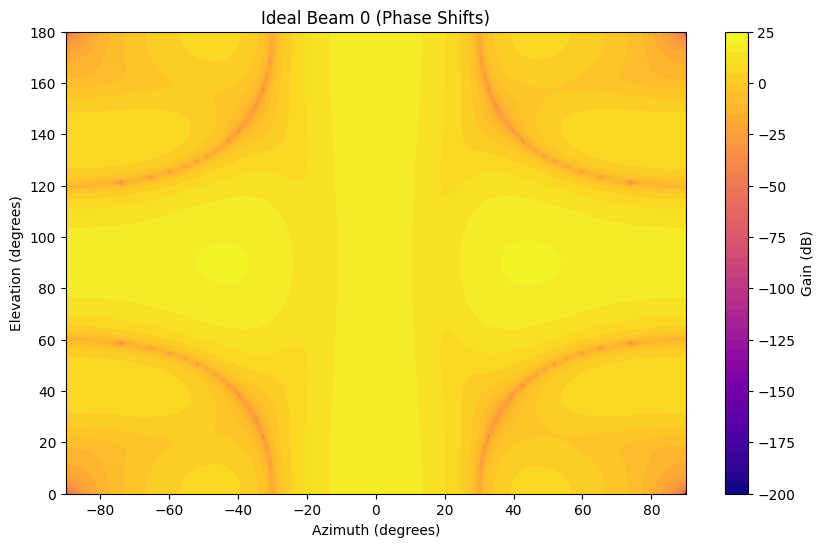

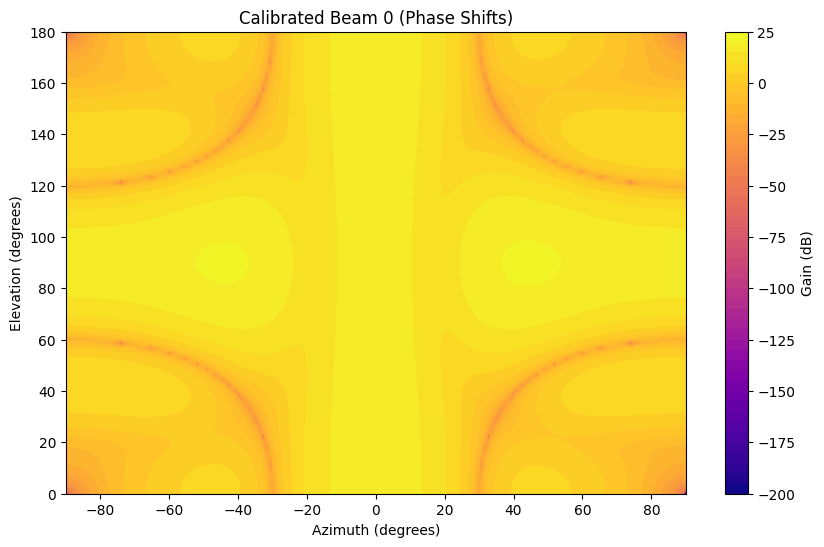

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm

# Load data (first 16 columns = TX phase shifts)
def load_beam_codebook(file_path):
    df = pd.read_csv(file_path, header=None)
    return df.iloc[:, :16].values.astype(str)  # Use first 16 columns

# Convert hex to phase (0x00 to 0x3F → 0 to 2π radians)
def hex_to_phase(hex_str):
    return (int(hex_str, 16) / 0x3F) * 2 * np.pi

# Simulate beam pattern for a 4x4 planar array with phase shifts
def simulate_beam_pattern_2d(weights, freq=60e9):
    wavelength = 3e8 / freq
    spacing = wavelength / 2
    theta = np.linspace(-np.pi/2, np.pi/2, 180)  # Azimuth
    phi = np.linspace(0, np.pi, 90)              # Elevation
    theta_grid, phi_grid = np.meshgrid(theta, phi)
    
    # 4x4 array positions
    x = np.arange(4) * spacing
    y = np.arange(4) * spacing
    xx, yy = np.meshgrid(x, y)
    positions = np.vstack([xx.ravel(), yy.ravel()]).T
    
    # Reshape weights to 4x4 and convert to complex phase shifts
    assert len(weights) == 16, f"Expected 16 phase weights, got {len(weights)}"
    phase_weights = np.reshape([hex_to_phase(w) for w in weights], (4, 4))
    complex_weights = np.exp(1j * phase_weights)  # e^(j*phase)
    
    # Array response
    beam_pattern = np.zeros_like(theta_grid)
    for i, t in enumerate(theta):
        for j, p in enumerate(phi):
            wave_vector = 2 * np.pi * np.array([np.sin(t) * np.cos(p), 
                                              np.sin(t) * np.sin(p)]) / wavelength
            phase_delays = np.exp(1j * (positions @ wave_vector))
            weighted_response = phase_delays * complex_weights.ravel()
            beam_pattern[j, i] = np.abs(np.sum(weighted_response))
    
    return np.degrees(theta_grid), np.degrees(phi_grid), beam_pattern

# Plot beam pattern
def plot_beam_2d(theta, phi, pattern, title):
    plt.figure(figsize=(10, 6))
    plt.contourf(theta, phi, 20 * np.log10(pattern + 1e-10), levels=50, cmap=cm.plasma)
    plt.colorbar(label="Gain (dB)")
    plt.title(title)
    plt.xlabel("Azimuth (degrees)")
    plt.ylabel("Elevation (degrees)")
    plt.show()

# Load and plot
beam_weights_ideal = load_beam_codebook("Antenna_beambook_ideal.csv")
beam_weights_calib = load_beam_codebook("Antenna_beambook.csv")

beam_idx = 0  # Beam index (0 to 63)
theta, phi, pattern_ideal = simulate_beam_pattern_2d(beam_weights_ideal[beam_idx])
plot_beam_2d(theta, phi, pattern_ideal, f"Ideal Beam {beam_idx} (Phase Shifts)")

theta, phi, pattern_calib = simulate_beam_pattern_2d(beam_weights_calib[beam_idx])
plot_beam_2d(theta, phi, pattern_calib, f"Calibrated Beam {beam_idx} (Phase Shifts)")

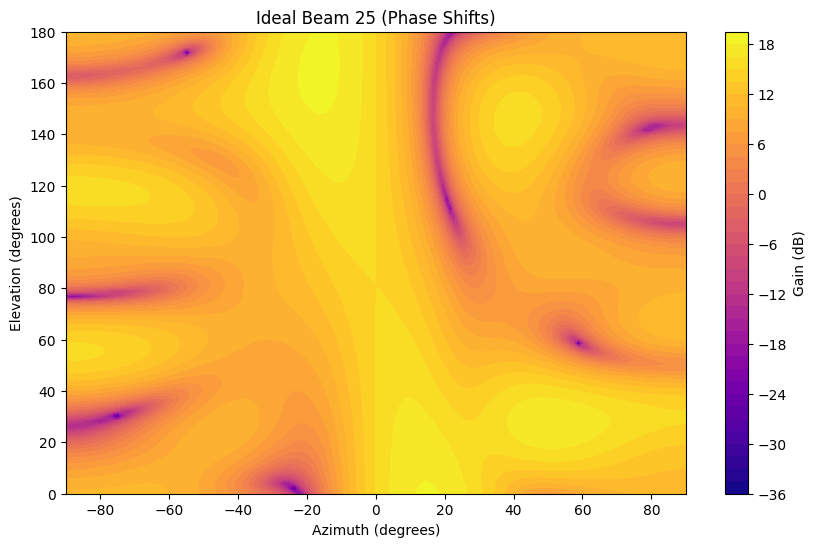

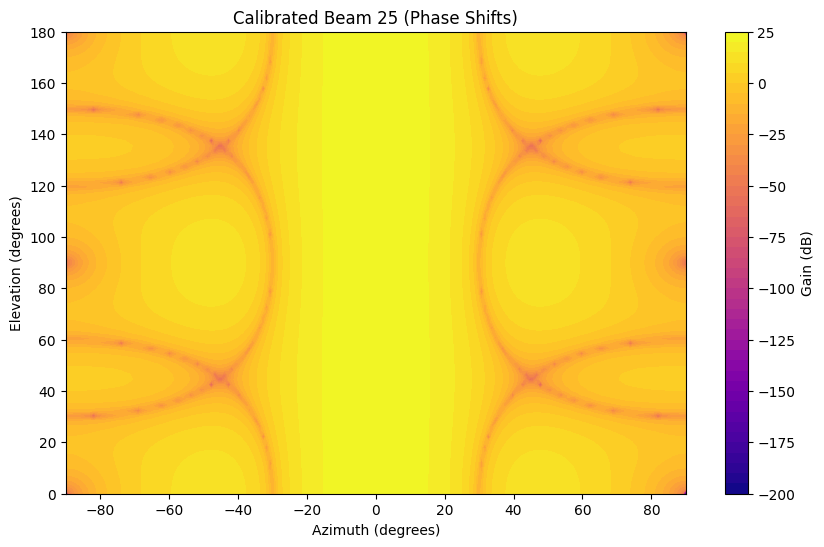

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm

# Load data (first 16 columns = TX phase shifts)
def load_beam_codebook(file_path):
    df = pd.read_csv(file_path, header=None)
    return df.iloc[:, :16].values.astype(str)  # Use first 16 columns

# Convert hex to phase (0x00 to 0x3F → 0 to 2π radians)
def hex_to_phase(hex_str):
    return (int(hex_str, 16) / 0x3F) * 2 * np.pi

# Simulate beam pattern for a 4x4 planar array with phase shifts
def simulate_beam_pattern_2d(weights, freq=60e9):
    wavelength = 3e8 / freq
    spacing = wavelength / 2
    theta = np.linspace(-np.pi/2, np.pi/2, 180)  # Azimuth
    phi = np.linspace(0, np.pi, 90)              # Elevation
    theta_grid, phi_grid = np.meshgrid(theta, phi)
    
    # 4x4 array positions
    x = np.arange(4) * spacing
    y = np.arange(4) * spacing
    xx, yy = np.meshgrid(x, y)
    positions = np.vstack([xx.ravel(), yy.ravel()]).T
    
    # Reshape weights to 4x4 and convert to complex phase shifts
    assert len(weights) == 16, f"Expected 16 phase weights, got {len(weights)}"
    phase_weights = np.reshape([hex_to_phase(w) for w in weights], (4, 4))
    complex_weights = np.exp(1j * phase_weights)  # e^(j*phase)
    
    # Array response
    beam_pattern = np.zeros_like(theta_grid)
    for i, t in enumerate(theta):
        for j, p in enumerate(phi):
            wave_vector = 2 * np.pi * np.array([np.sin(t) * np.cos(p), 
                                              np.sin(t) * np.sin(p)]) / wavelength
            phase_delays = np.exp(1j * (positions @ wave_vector))
            weighted_response = phase_delays * complex_weights.ravel()
            beam_pattern[j, i] = np.abs(np.sum(weighted_response))
    
    return np.degrees(theta_grid), np.degrees(phi_grid), beam_pattern

# Plot beam pattern
def plot_beam_2d(theta, phi, pattern, title):
    plt.figure(figsize=(10, 6))
    plt.contourf(theta, phi, 20 * np.log10(pattern + 1e-10), levels=50, cmap=cm.plasma)
    plt.colorbar(label="Gain (dB)")
    plt.title(title)
    plt.xlabel("Azimuth (degrees)")
    plt.ylabel("Elevation (degrees)")
    plt.show()

# Load and plot
beam_weights_ideal = load_beam_codebook("Antenna_beambook_ideal.csv")
beam_weights_calib = load_beam_codebook("Antenna_beambook.csv")

beam_idx = 25  # Beam index (0 to 63)
theta, phi, pattern_ideal = simulate_beam_pattern_2d(beam_weights_ideal[beam_idx])
plot_beam_2d(theta, phi, pattern_ideal, f"Ideal Beam {beam_idx} (Phase Shifts)")

theta, phi, pattern_calib = simulate_beam_pattern_2d(beam_weights_calib[beam_idx])
plot_beam_2d(theta, phi, pattern_calib, f"Calibrated Beam {beam_idx} (Phase Shifts)")

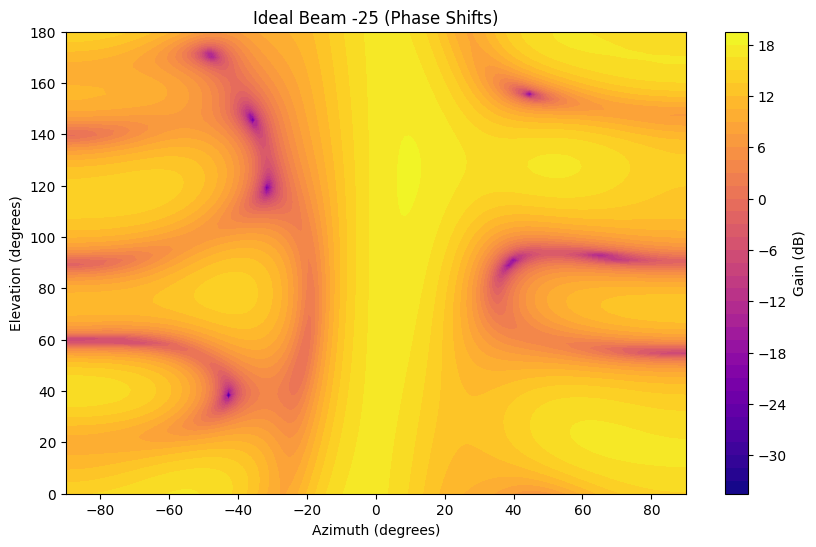

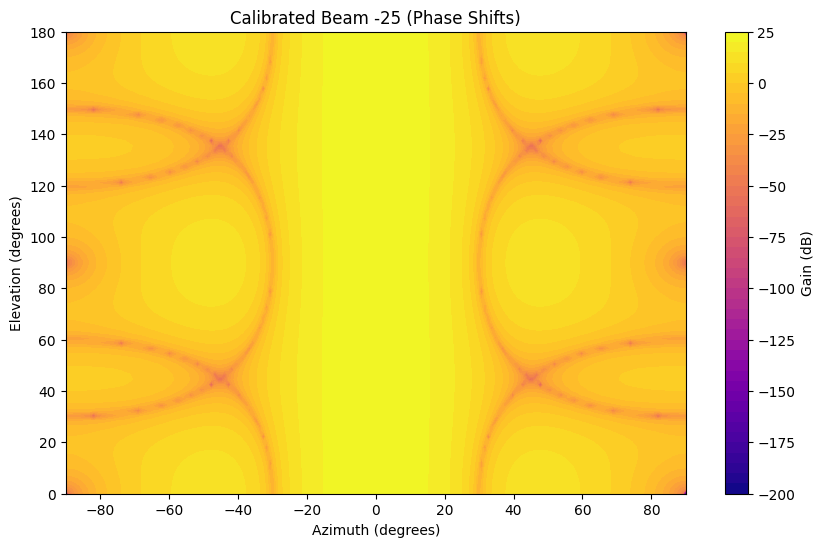

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm

# Load data (first 16 columns = TX phase shifts)
def load_beam_codebook(file_path):
    df = pd.read_csv(file_path, header=None)
    return df.iloc[:, :16].values.astype(str)  # Use first 16 columns

# Convert hex to phase (0x00 to 0x3F → 0 to 2π radians)
def hex_to_phase(hex_str):
    return (int(hex_str, 16) / 0x3F) * 2 * np.pi

# Simulate beam pattern for a 4x4 planar array with phase shifts
def simulate_beam_pattern_2d(weights, freq=60e9):
    wavelength = 3e8 / freq
    spacing = wavelength / 2
    theta = np.linspace(-np.pi/2, np.pi/2, 180)  # Azimuth
    phi = np.linspace(0, np.pi, 90)              # Elevation
    theta_grid, phi_grid = np.meshgrid(theta, phi)
    
    # 4x4 array positions
    x = np.arange(4) * spacing
    y = np.arange(4) * spacing
    xx, yy = np.meshgrid(x, y)
    positions = np.vstack([xx.ravel(), yy.ravel()]).T
    
    # Reshape weights to 4x4 and convert to complex phase shifts
    assert len(weights) == 16, f"Expected 16 phase weights, got {len(weights)}"
    phase_weights = np.reshape([hex_to_phase(w) for w in weights], (4, 4))
    complex_weights = np.exp(1j * phase_weights)  # e^(j*phase)
    
    # Array response
    beam_pattern = np.zeros_like(theta_grid)
    for i, t in enumerate(theta):
        for j, p in enumerate(phi):
            wave_vector = 2 * np.pi * np.array([np.sin(t) * np.cos(p), 
                                              np.sin(t) * np.sin(p)]) / wavelength
            phase_delays = np.exp(1j * (positions @ wave_vector))
            weighted_response = phase_delays * complex_weights.ravel()
            beam_pattern[j, i] = np.abs(np.sum(weighted_response))
    
    return np.degrees(theta_grid), np.degrees(phi_grid), beam_pattern

# Plot beam pattern
def plot_beam_2d(theta, phi, pattern, title):
    plt.figure(figsize=(10, 6))
    plt.contourf(theta, phi, 20 * np.log10(pattern + 1e-10), levels=50, cmap=cm.plasma)
    plt.colorbar(label="Gain (dB)")
    plt.title(title)
    plt.xlabel("Azimuth (degrees)")
    plt.ylabel("Elevation (degrees)")
    plt.show()

# Load and plot
beam_weights_ideal = load_beam_codebook("Antenna_beambook_ideal.csv")
beam_weights_calib = load_beam_codebook("Antenna_beambook.csv")

beam_idx = -25  # Beam index (0 to 63)
theta, phi, pattern_ideal = simulate_beam_pattern_2d(beam_weights_ideal[beam_idx])
plot_beam_2d(theta, phi, pattern_ideal, f"Ideal Beam {beam_idx} (Phase Shifts)")

theta, phi, pattern_calib = simulate_beam_pattern_2d(beam_weights_calib[beam_idx])
plot_beam_2d(theta, phi, pattern_calib, f"Calibrated Beam {beam_idx} (Phase Shifts)")

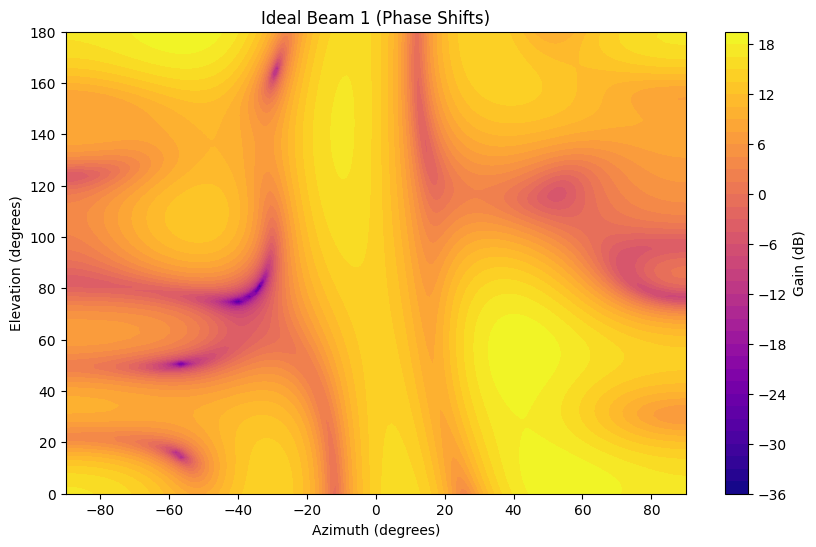

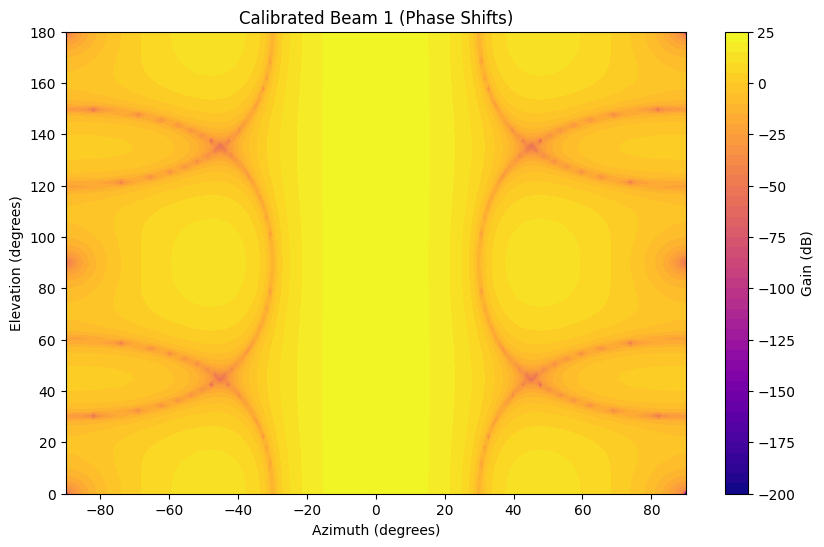

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm

# Load data (first 16 columns = TX phase shifts)
def load_beam_codebook(file_path):
    df = pd.read_csv(file_path, header=None)
    return df.iloc[:, :16].values.astype(str)  # Use first 16 columns

# Convert hex to phase (0x00 to 0x3F → 0 to 2π radians)
def hex_to_phase(hex_str):
    return (int(hex_str, 16) / 0x3F) * 2 * np.pi

# Simulate beam pattern for a 4x4 planar array with phase shifts
def simulate_beam_pattern_2d(weights, freq=60e9):
    wavelength = 3e8 / freq
    spacing = wavelength / 2
    theta = np.linspace(-np.pi/2, np.pi/2, 180)  # Azimuth
    phi = np.linspace(0, np.pi, 90)              # Elevation
    theta_grid, phi_grid = np.meshgrid(theta, phi)
    
    # 4x4 array positions
    x = np.arange(4) * spacing
    y = np.arange(4) * spacing
    xx, yy = np.meshgrid(x, y)
    positions = np.vstack([xx.ravel(), yy.ravel()]).T
    
    # Reshape weights to 4x4 and convert to complex phase shifts
    assert len(weights) == 16, f"Expected 16 phase weights, got {len(weights)}"
    phase_weights = np.reshape([hex_to_phase(w) for w in weights], (4, 4))
    complex_weights = np.exp(1j * phase_weights)  # e^(j*phase)
    
    # Array response
    beam_pattern = np.zeros_like(theta_grid)
    for i, t in enumerate(theta):
        for j, p in enumerate(phi):
            wave_vector = 2 * np.pi * np.array([np.sin(t) * np.cos(p), 
                                              np.sin(t) * np.sin(p)]) / wavelength
            phase_delays = np.exp(1j * (positions @ wave_vector))
            weighted_response = phase_delays * complex_weights.ravel()
            beam_pattern[j, i] = np.abs(np.sum(weighted_response))
    
    return np.degrees(theta_grid), np.degrees(phi_grid), beam_pattern

# Plot beam pattern
def plot_beam_2d(theta, phi, pattern, title):
    plt.figure(figsize=(10, 6))
    plt.contourf(theta, phi, 20 * np.log10(pattern + 1e-10), levels=50, cmap=cm.plasma)
    plt.colorbar(label="Gain (dB)")
    plt.title(title)
    plt.xlabel("Azimuth (degrees)")
    plt.ylabel("Elevation (degrees)")
    plt.show()

# Load and plot
beam_weights_ideal = load_beam_codebook("Antenna_beambook_ideal.csv")
beam_weights_calib = load_beam_codebook("Antenna_beambook.csv")

beam_idx = 1  # Beam index (0 to 63)
theta, phi, pattern_ideal = simulate_beam_pattern_2d(beam_weights_ideal[beam_idx])
plot_beam_2d(theta, phi, pattern_ideal, f"Ideal Beam {beam_idx} (Phase Shifts)")

theta, phi, pattern_calib = simulate_beam_pattern_2d(beam_weights_calib[beam_idx])
plot_beam_2d(theta, phi, pattern_calib, f"Calibrated Beam {beam_idx} (Phase Shifts)")

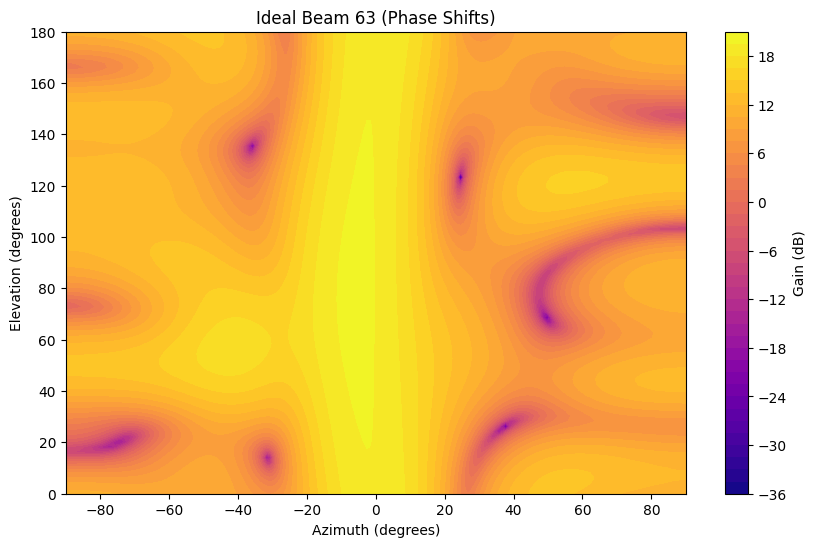

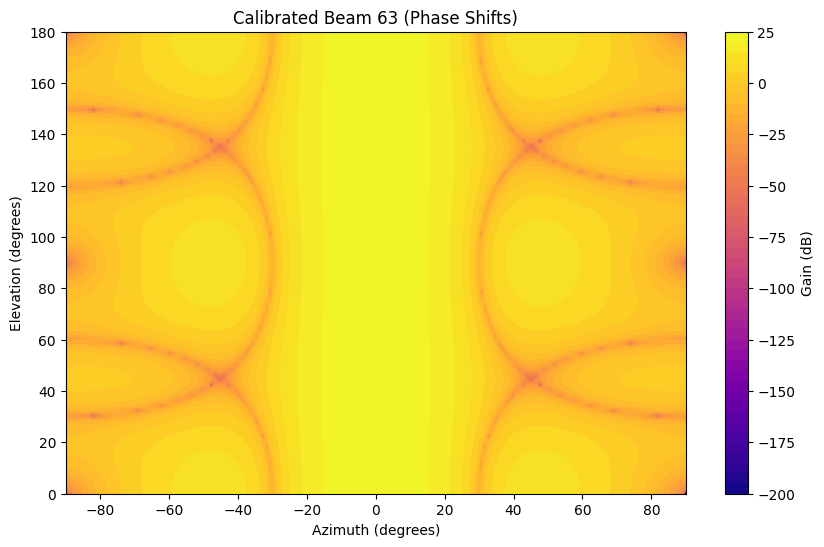

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm

# Load data (first 16 columns = TX phase shifts)
def load_beam_codebook(file_path):
    df = pd.read_csv(file_path, header=None)
    return df.iloc[:, :16].values.astype(str)  # Use first 16 columns

# Convert hex to phase (0x00 to 0x3F → 0 to 2π radians)
def hex_to_phase(hex_str):
    return (int(hex_str, 16) / 0x3F) * 2 * np.pi

# Simulate beam pattern for a 4x4 planar array with phase shifts
def simulate_beam_pattern_2d(weights, freq=60e9):
    wavelength = 3e8 / freq
    spacing = wavelength / 2
    theta = np.linspace(-np.pi/2, np.pi/2, 180)  # Azimuth
    phi = np.linspace(0, np.pi, 90)              # Elevation
    theta_grid, phi_grid = np.meshgrid(theta, phi)
    
    # 4x4 array positions
    x = np.arange(4) * spacing
    y = np.arange(4) * spacing
    xx, yy = np.meshgrid(x, y)
    positions = np.vstack([xx.ravel(), yy.ravel()]).T
    
    # Reshape weights to 4x4 and convert to complex phase shifts
    assert len(weights) == 16, f"Expected 16 phase weights, got {len(weights)}"
    phase_weights = np.reshape([hex_to_phase(w) for w in weights], (4, 4))
    complex_weights = np.exp(1j * phase_weights)  # e^(j*phase)
    
    # Array response
    beam_pattern = np.zeros_like(theta_grid)
    for i, t in enumerate(theta):
        for j, p in enumerate(phi):
            wave_vector = 2 * np.pi * np.array([np.sin(t) * np.cos(p), 
                                              np.sin(t) * np.sin(p)]) / wavelength
            phase_delays = np.exp(1j * (positions @ wave_vector))
            weighted_response = phase_delays * complex_weights.ravel()
            beam_pattern[j, i] = np.abs(np.sum(weighted_response))
    
    return np.degrees(theta_grid), np.degrees(phi_grid), beam_pattern

# Plot beam pattern
def plot_beam_2d(theta, phi, pattern, title):
    plt.figure(figsize=(10, 6))
    plt.contourf(theta, phi, 20 * np.log10(pattern + 1e-10), levels=50, cmap=cm.plasma)
    plt.colorbar(label="Gain (dB)")
    plt.title(title)
    plt.xlabel("Azimuth (degrees)")
    plt.ylabel("Elevation (degrees)")
    plt.show()

# Load and plot
beam_weights_ideal = load_beam_codebook("Antenna_beambook_ideal.csv")
beam_weights_calib = load_beam_codebook("Antenna_beambook.csv")

beam_idx = 63  # Beam index (0 to 63)
theta, phi, pattern_ideal = simulate_beam_pattern_2d(beam_weights_ideal[beam_idx])
plot_beam_2d(theta, phi, pattern_ideal, f"Ideal Beam {beam_idx} (Phase Shifts)")

theta, phi, pattern_calib = simulate_beam_pattern_2d(beam_weights_calib[beam_idx])
plot_beam_2d(theta, phi, pattern_calib, f"Calibrated Beam {beam_idx} (Phase Shifts)")

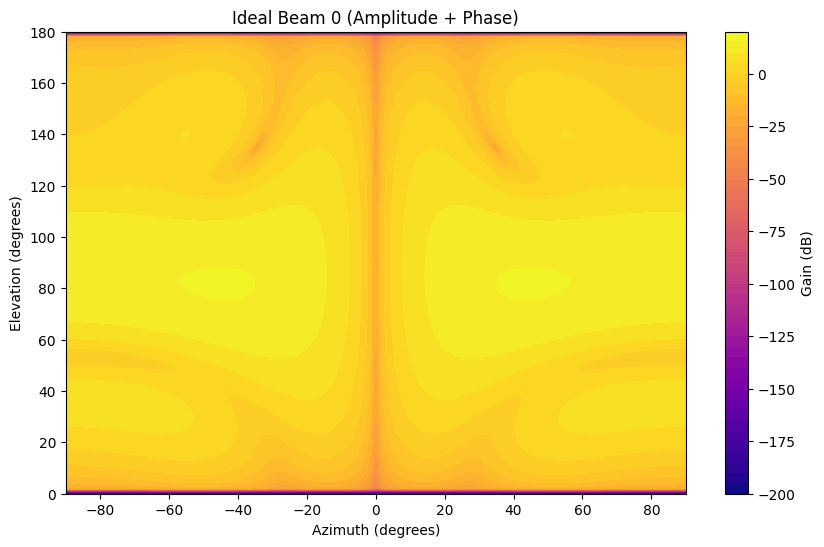

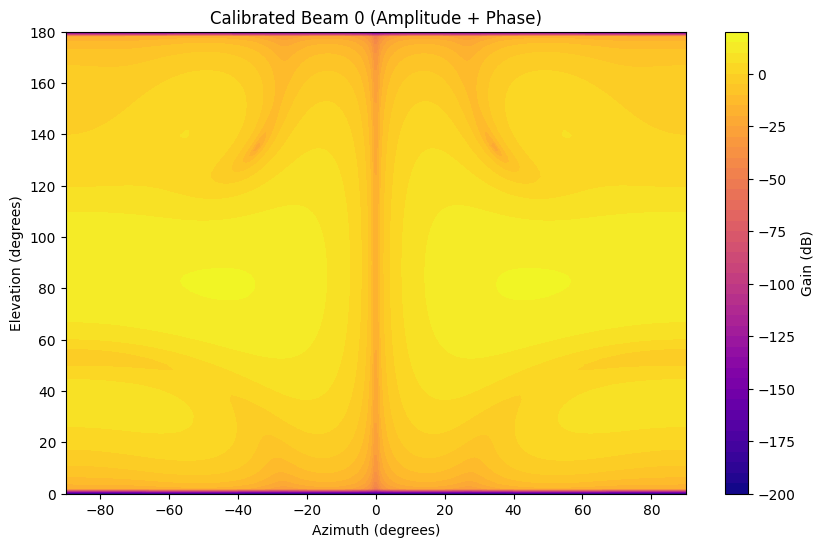

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm

# Load data (first 16 columns = TX weights)
def load_beam_codebook(file_path):
    df = pd.read_csv(file_path, header=None)
    return df.iloc[:, :16].values.astype(str)  # Use first 16 columns

# Convert hex to complex weights (amplitude + phase)
def hex_to_complex(hex_str):
    val = int(hex_str, 16)          # Hex to integer (0-63)
    phase = (val >> 3) / 8 * 2 * np.pi  # Upper 3 bits → phase [0, 2π]
    amp = (val & 0x7) / 8           # Lower 3 bits → amplitude [0, 1]
    return amp * np.exp(1j * phase)  # Complex weight

# Simulate beam pattern for a 4x4 planar array
def simulate_beam_pattern_2d(weights, freq=60e9):
    wavelength = 3e8 / freq
    spacing = wavelength / 2
    theta = np.linspace(-np.pi/2, np.pi/2, 180)  # Azimuth
    phi = np.linspace(0, np.pi, 90)              # Elevation
    theta_grid, phi_grid = np.meshgrid(theta, phi)
    
    # 4x4 array positions
    x = np.arange(4) * spacing
    y = np.arange(4) * spacing
    xx, yy = np.meshgrid(x, y)
    positions = np.vstack([xx.ravel(), yy.ravel()]).T
    
    # Reshape weights to 4x4 complex array
    assert len(weights) == 16, f"Expected 16 weights, got {len(weights)}"
    weights_2d = np.reshape([hex_to_complex(w) for w in weights], (4, 4))
    
    # Array response
    beam_pattern = np.zeros_like(theta_grid)
    for i, t in enumerate(theta):
        for j, p in enumerate(phi):
            wave_vector = 2 * np.pi * np.array([np.sin(t) * np.cos(p), 
                                              np.sin(t) * np.sin(p)]) / wavelength
            phase_delays = np.exp(1j * (positions @ wave_vector))
            weighted_response = phase_delays * weights_2d.ravel()
            beam_pattern[j, i] = np.abs(np.sum(weighted_response))
    
    return np.degrees(theta_grid), np.degrees(phi_grid), beam_pattern

# Plot beam pattern
def plot_beam_2d(theta, phi, pattern, title):
    plt.figure(figsize=(10, 6))
    plt.contourf(theta, phi, 20 * np.log10(pattern + 1e-10), levels=50, cmap=cm.plasma)
    plt.colorbar(label="Gain (dB)")
    plt.title(title)
    plt.xlabel("Azimuth (degrees)")
    plt.ylabel("Elevation (degrees)")
    plt.show()

# Load and plot
beam_weights_ideal = load_beam_codebook("Antenna_beambook_ideal.csv")
beam_weights_calib = load_beam_codebook("Antenna_beambook.csv")

beam_idx = 0  # Beam index (0 to 63)
theta, phi, pattern_ideal = simulate_beam_pattern_2d(beam_weights_ideal[beam_idx])
plot_beam_2d(theta, phi, pattern_ideal, f"Ideal Beam {beam_idx} (Amplitude + Phase)")

theta, phi, pattern_calib = simulate_beam_pattern_2d(beam_weights_calib[beam_idx])
plot_beam_2d(theta, phi, pattern_calib, f"Calibrated Beam {beam_idx} (Amplitude + Phase)")

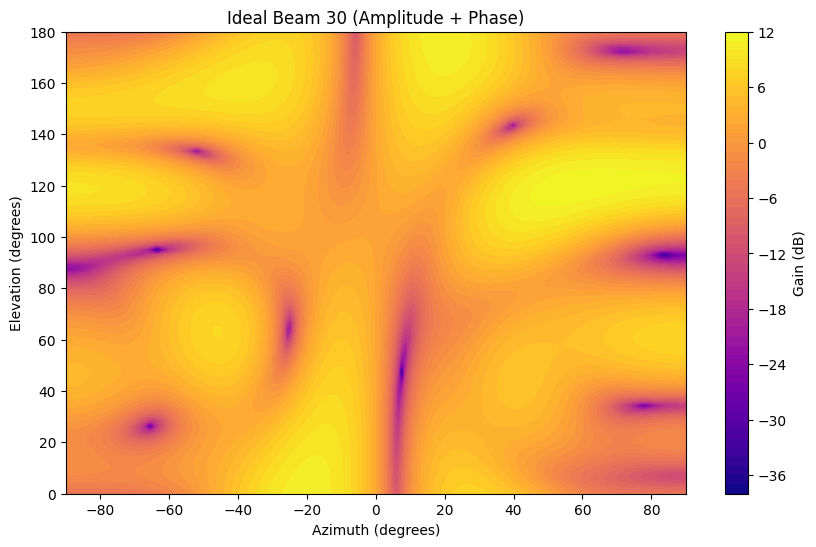

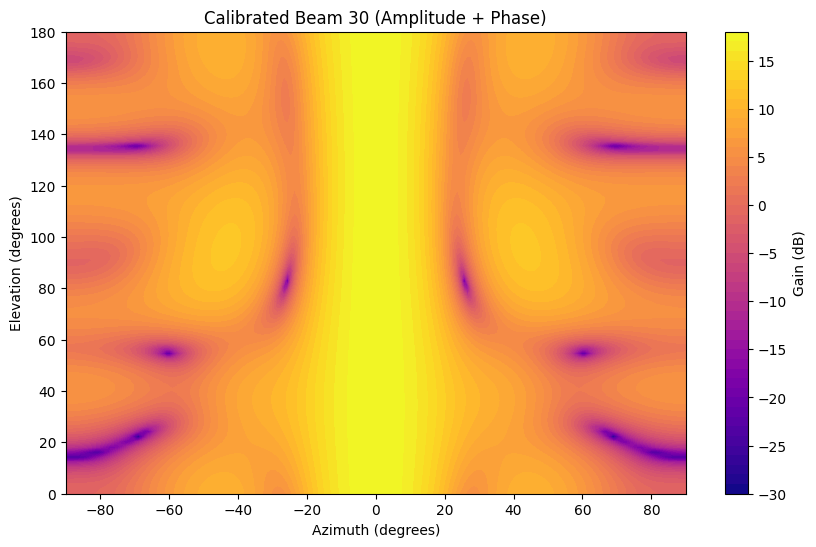

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm

# Load data (first 16 columns = TX weights)
def load_beam_codebook(file_path):
    df = pd.read_csv(file_path, header=None)
    return df.iloc[:, :16].values.astype(str)  # Use first 16 columns

# Convert hex to complex weights (amplitude + phase)
def hex_to_complex(hex_str):
    val = int(hex_str, 16)          # Hex to integer (0-63)
    phase = (val >> 3) / 8 * 2 * np.pi  # Upper 3 bits → phase [0, 2π]
    amp = (val & 0x7) / 8           # Lower 3 bits → amplitude [0, 1]
    return amp * np.exp(1j * phase)  # Complex weight

# Simulate beam pattern for a 4x4 planar array
def simulate_beam_pattern_2d(weights, freq=60e9):
    wavelength = 3e8 / freq
    spacing = wavelength / 2
    theta = np.linspace(-np.pi/2, np.pi/2, 180)  # Azimuth
    phi = np.linspace(0, np.pi, 90)              # Elevation
    theta_grid, phi_grid = np.meshgrid(theta, phi)
    
    # 4x4 array positions
    x = np.arange(4) * spacing
    y = np.arange(4) * spacing
    xx, yy = np.meshgrid(x, y)
    positions = np.vstack([xx.ravel(), yy.ravel()]).T
    
    # Reshape weights to 4x4 complex array
    assert len(weights) == 16, f"Expected 16 weights, got {len(weights)}"
    weights_2d = np.reshape([hex_to_complex(w) for w in weights], (4, 4))
    
    # Array response
    beam_pattern = np.zeros_like(theta_grid)
    for i, t in enumerate(theta):
        for j, p in enumerate(phi):
            wave_vector = 2 * np.pi * np.array([np.sin(t) * np.cos(p), 
                                              np.sin(t) * np.sin(p)]) / wavelength
            phase_delays = np.exp(1j * (positions @ wave_vector))
            weighted_response = phase_delays * weights_2d.ravel()
            beam_pattern[j, i] = np.abs(np.sum(weighted_response))
    
    return np.degrees(theta_grid), np.degrees(phi_grid), beam_pattern

# Plot beam pattern
def plot_beam_2d(theta, phi, pattern, title):
    plt.figure(figsize=(10, 6))
    plt.contourf(theta, phi, 20 * np.log10(pattern + 1e-10), levels=50, cmap=cm.plasma)
    plt.colorbar(label="Gain (dB)")
    plt.title(title)
    plt.xlabel("Azimuth (degrees)")
    plt.ylabel("Elevation (degrees)")
    plt.show()

# Load and plot
beam_weights_ideal = load_beam_codebook("Antenna_beambook_ideal.csv")
beam_weights_calib = load_beam_codebook("Antenna_beambook.csv")

beam_idx = 30  # Beam index (0 to 63)
theta, phi, pattern_ideal = simulate_beam_pattern_2d(beam_weights_ideal[beam_idx])
plot_beam_2d(theta, phi, pattern_ideal, f"Ideal Beam {beam_idx} (Amplitude + Phase)")

theta, phi, pattern_calib = simulate_beam_pattern_2d(beam_weights_calib[beam_idx])
plot_beam_2d(theta, phi, pattern_calib, f"Calibrated Beam {beam_idx} (Amplitude + Phase)")

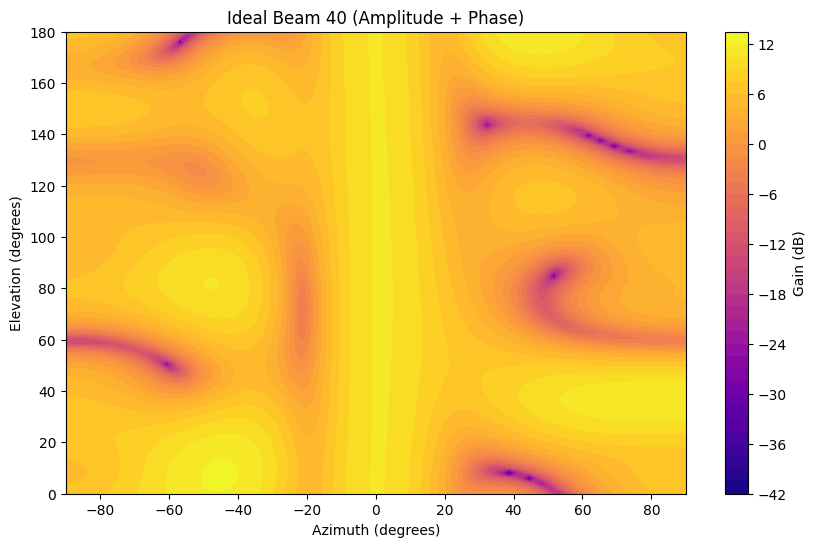

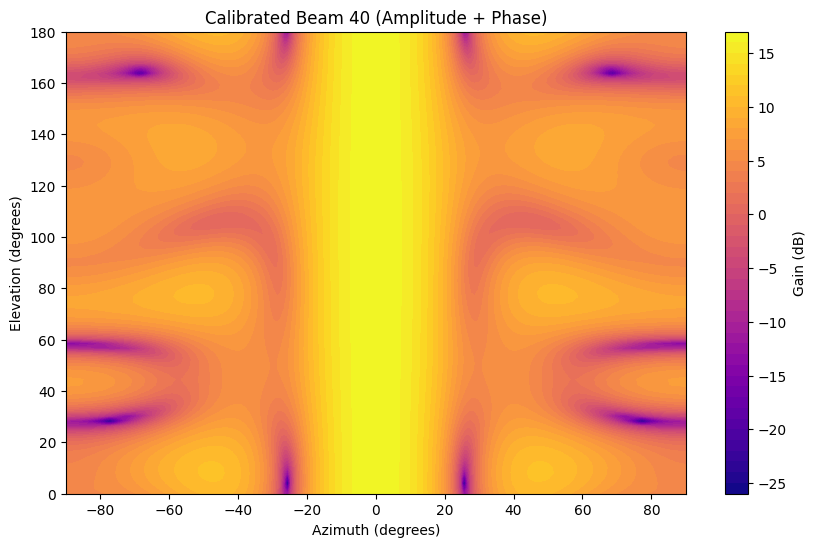

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm

# Load data (first 16 columns = TX weights)
def load_beam_codebook(file_path):
    df = pd.read_csv(file_path, header=None)
    return df.iloc[:, :16].values.astype(str)  # Use first 16 columns

# Convert hex to complex weights (amplitude + phase)
def hex_to_complex(hex_str):
    val = int(hex_str, 16)          # Hex to integer (0-63)
    phase = (val >> 3) / 8 * 2 * np.pi  # Upper 3 bits → phase [0, 2π]
    amp = (val & 0x7) / 8           # Lower 3 bits → amplitude [0, 1]
    return amp * np.exp(1j * phase)  # Complex weight

# Simulate beam pattern for a 4x4 planar array
def simulate_beam_pattern_2d(weights, freq=60e9):
    wavelength = 3e8 / freq
    spacing = wavelength / 2
    theta = np.linspace(-np.pi/2, np.pi/2, 180)  # Azimuth
    phi = np.linspace(0, np.pi, 90)              # Elevation
    theta_grid, phi_grid = np.meshgrid(theta, phi)
    
    # 4x4 array positions
    x = np.arange(4) * spacing
    y = np.arange(4) * spacing
    xx, yy = np.meshgrid(x, y)
    positions = np.vstack([xx.ravel(), yy.ravel()]).T
    
    # Reshape weights to 4x4 complex array
    assert len(weights) == 16, f"Expected 16 weights, got {len(weights)}"
    weights_2d = np.reshape([hex_to_complex(w) for w in weights], (4, 4))
    
    # Array response
    beam_pattern = np.zeros_like(theta_grid)
    for i, t in enumerate(theta):
        for j, p in enumerate(phi):
            wave_vector = 2 * np.pi * np.array([np.sin(t) * np.cos(p), 
                                              np.sin(t) * np.sin(p)]) / wavelength
            phase_delays = np.exp(1j * (positions @ wave_vector))
            weighted_response = phase_delays * weights_2d.ravel()
            beam_pattern[j, i] = np.abs(np.sum(weighted_response))
    
    return np.degrees(theta_grid), np.degrees(phi_grid), beam_pattern

# Plot beam pattern
def plot_beam_2d(theta, phi, pattern, title):
    plt.figure(figsize=(10, 6))
    plt.contourf(theta, phi, 20 * np.log10(pattern + 1e-10), levels=50, cmap=cm.plasma)
    plt.colorbar(label="Gain (dB)")
    plt.title(title)
    plt.xlabel("Azimuth (degrees)")
    plt.ylabel("Elevation (degrees)")
    plt.show()

# Load and plot
beam_weights_ideal = load_beam_codebook("Antenna_beambook_ideal.csv")
beam_weights_calib = load_beam_codebook("Antenna_beambook.csv")

beam_idx = 40  # Beam index (0 to 63)
theta, phi, pattern_ideal = simulate_beam_pattern_2d(beam_weights_ideal[beam_idx])
plot_beam_2d(theta, phi, pattern_ideal, f"Ideal Beam {beam_idx} (Amplitude + Phase)")

theta, phi, pattern_calib = simulate_beam_pattern_2d(beam_weights_calib[beam_idx])
plot_beam_2d(theta, phi, pattern_calib, f"Calibrated Beam {beam_idx} (Amplitude + Phase)")

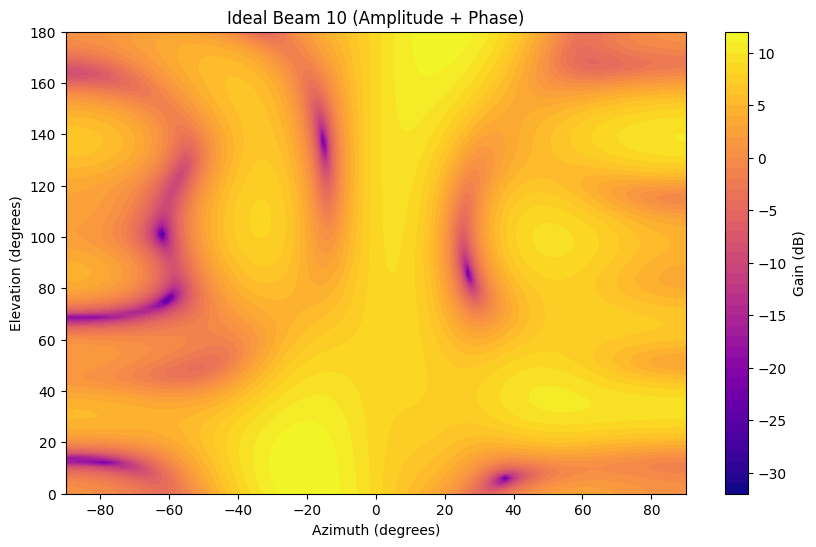

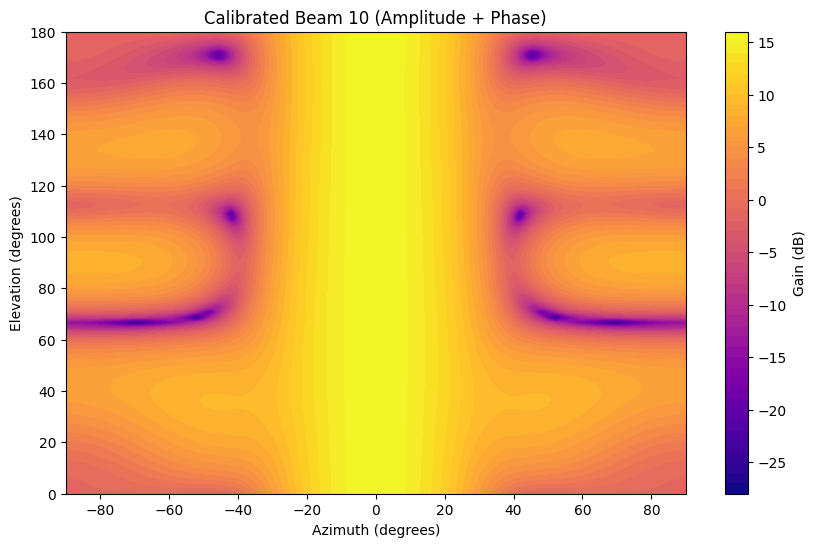

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm

# Load data (first 16 columns = TX weights)
def load_beam_codebook(file_path):
    df = pd.read_csv(file_path, header=None)
    return df.iloc[:, :16].values.astype(str)  # Use first 16 columns

# Convert hex to complex weights (amplitude + phase)
def hex_to_complex(hex_str):
    val = int(hex_str, 16)          # Hex to integer (0-63)
    phase = (val >> 3) / 8 * 2 * np.pi  # Upper 3 bits → phase [0, 2π]
    amp = (val & 0x7) / 8           # Lower 3 bits → amplitude [0, 1]
    return amp * np.exp(1j * phase)  # Complex weight

# Simulate beam pattern for a 4x4 planar array
def simulate_beam_pattern_2d(weights, freq=60e9):
    wavelength = 3e8 / freq
    spacing = wavelength / 2
    theta = np.linspace(-np.pi/2, np.pi/2, 180)  # Azimuth
    phi = np.linspace(0, np.pi, 90)              # Elevation
    theta_grid, phi_grid = np.meshgrid(theta, phi)
    
    # 4x4 array positions
    x = np.arange(4) * spacing
    y = np.arange(4) * spacing
    xx, yy = np.meshgrid(x, y)
    positions = np.vstack([xx.ravel(), yy.ravel()]).T
    
    # Reshape weights to 4x4 complex array
    assert len(weights) == 16, f"Expected 16 weights, got {len(weights)}"
    weights_2d = np.reshape([hex_to_complex(w) for w in weights], (4, 4))
    
    # Array response
    beam_pattern = np.zeros_like(theta_grid)
    for i, t in enumerate(theta):
        for j, p in enumerate(phi):
            wave_vector = 2 * np.pi * np.array([np.sin(t) * np.cos(p), 
                                              np.sin(t) * np.sin(p)]) / wavelength
            phase_delays = np.exp(1j * (positions @ wave_vector))
            weighted_response = phase_delays * weights_2d.ravel()
            beam_pattern[j, i] = np.abs(np.sum(weighted_response))
    
    return np.degrees(theta_grid), np.degrees(phi_grid), beam_pattern

# Plot beam pattern
def plot_beam_2d(theta, phi, pattern, title):
    plt.figure(figsize=(10, 6))
    plt.contourf(theta, phi, 20 * np.log10(pattern + 1e-10), levels=50, cmap=cm.plasma)
    plt.colorbar(label="Gain (dB)")
    plt.title(title)
    plt.xlabel("Azimuth (degrees)")
    plt.ylabel("Elevation (degrees)")
    plt.show()

# Load and plot
beam_weights_ideal = load_beam_codebook("Antenna_beambook_ideal.csv")
beam_weights_calib = load_beam_codebook("Antenna_beambook.csv")

beam_idx = 10  # Beam index (0 to 63)
theta, phi, pattern_ideal = simulate_beam_pattern_2d(beam_weights_ideal[beam_idx])
plot_beam_2d(theta, phi, pattern_ideal, f"Ideal Beam {beam_idx} (Amplitude + Phase)")

theta, phi, pattern_calib = simulate_beam_pattern_2d(beam_weights_calib[beam_idx])
plot_beam_2d(theta, phi, pattern_calib, f"Calibrated Beam {beam_idx} (Amplitude + Phase)")

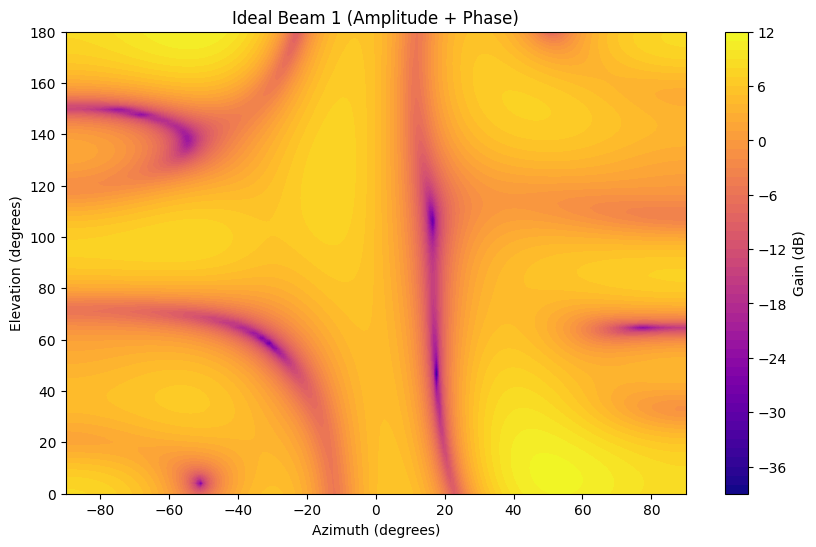

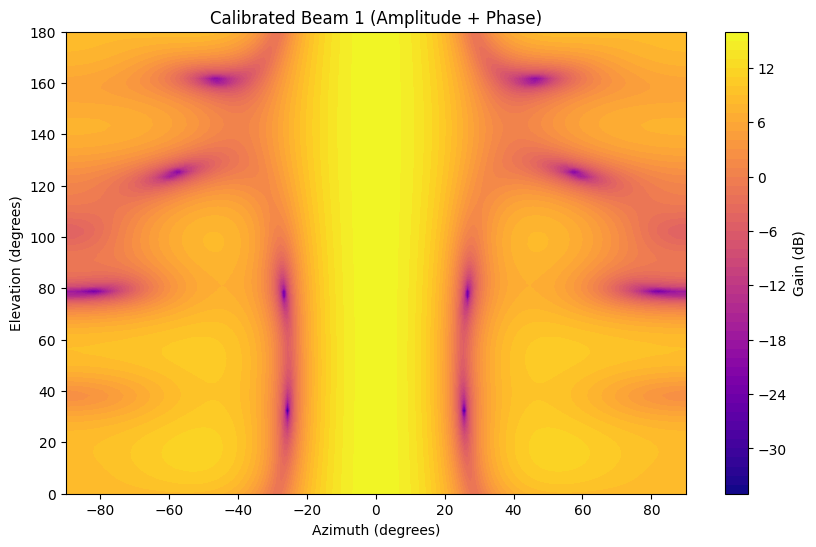

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm

# Load data (first 16 columns = TX weights)
def load_beam_codebook(file_path):
    df = pd.read_csv(file_path, header=None)
    return df.iloc[:, :16].values.astype(str)  # Use first 16 columns

# Convert hex to complex weights (amplitude + phase)
def hex_to_complex(hex_str):
    val = int(hex_str, 16)          # Hex to integer (0-63)
    phase = (val >> 3) / 8 * 2 * np.pi  # Upper 3 bits → phase [0, 2π]
    amp = (val & 0x7) / 8           # Lower 3 bits → amplitude [0, 1]
    return amp * np.exp(1j * phase)  # Complex weight

# Simulate beam pattern for a 4x4 planar array
def simulate_beam_pattern_2d(weights, freq=60e9):
    wavelength = 3e8 / freq
    spacing = wavelength / 2
    theta = np.linspace(-np.pi/2, np.pi/2, 180)  # Azimuth
    phi = np.linspace(0, np.pi, 90)              # Elevation
    theta_grid, phi_grid = np.meshgrid(theta, phi)
    
    # 4x4 array positions
    x = np.arange(4) * spacing
    y = np.arange(4) * spacing
    xx, yy = np.meshgrid(x, y)
    positions = np.vstack([xx.ravel(), yy.ravel()]).T
    
    # Reshape weights to 4x4 complex array
    assert len(weights) == 16, f"Expected 16 weights, got {len(weights)}"
    weights_2d = np.reshape([hex_to_complex(w) for w in weights], (4, 4))
    
    # Array response
    beam_pattern = np.zeros_like(theta_grid)
    for i, t in enumerate(theta):
        for j, p in enumerate(phi):
            wave_vector = 2 * np.pi * np.array([np.sin(t) * np.cos(p), 
                                              np.sin(t) * np.sin(p)]) / wavelength
            phase_delays = np.exp(1j * (positions @ wave_vector))
            weighted_response = phase_delays * weights_2d.ravel()
            beam_pattern[j, i] = np.abs(np.sum(weighted_response))
    
    return np.degrees(theta_grid), np.degrees(phi_grid), beam_pattern

# Plot beam pattern
def plot_beam_2d(theta, phi, pattern, title):
    plt.figure(figsize=(10, 6))
    plt.contourf(theta, phi, 20 * np.log10(pattern + 1e-10), levels=50, cmap=cm.plasma)
    plt.colorbar(label="Gain (dB)")
    plt.title(title)
    plt.xlabel("Azimuth (degrees)")
    plt.ylabel("Elevation (degrees)")
    plt.show()

# Load and plot
beam_weights_ideal = load_beam_codebook("Antenna_beambook_ideal.csv")
beam_weights_calib = load_beam_codebook("Antenna_beambook.csv")

beam_idx = 1  # Beam index (0 to 63)
theta, phi, pattern_ideal = simulate_beam_pattern_2d(beam_weights_ideal[beam_idx])
plot_beam_2d(theta, phi, pattern_ideal, f"Ideal Beam {beam_idx} (Amplitude + Phase)")

theta, phi, pattern_calib = simulate_beam_pattern_2d(beam_weights_calib[beam_idx])
plot_beam_2d(theta, phi, pattern_calib, f"Calibrated Beam {beam_idx} (Amplitude + Phase)")

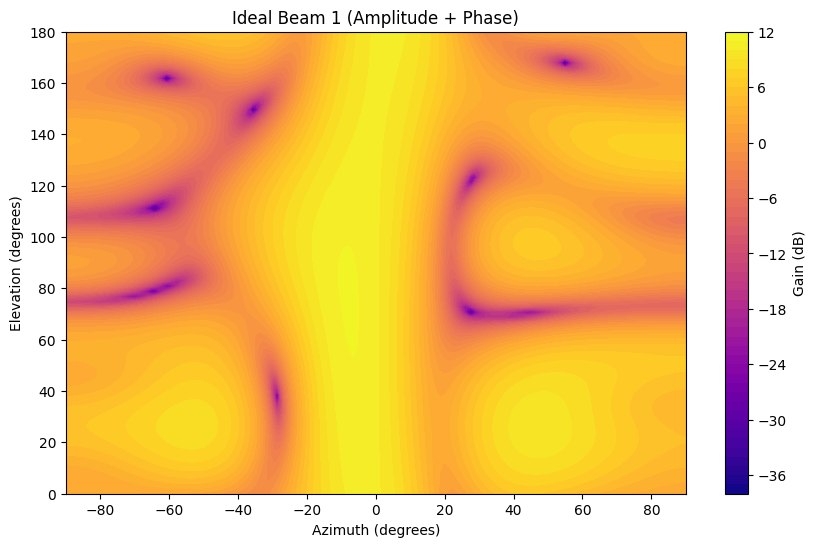

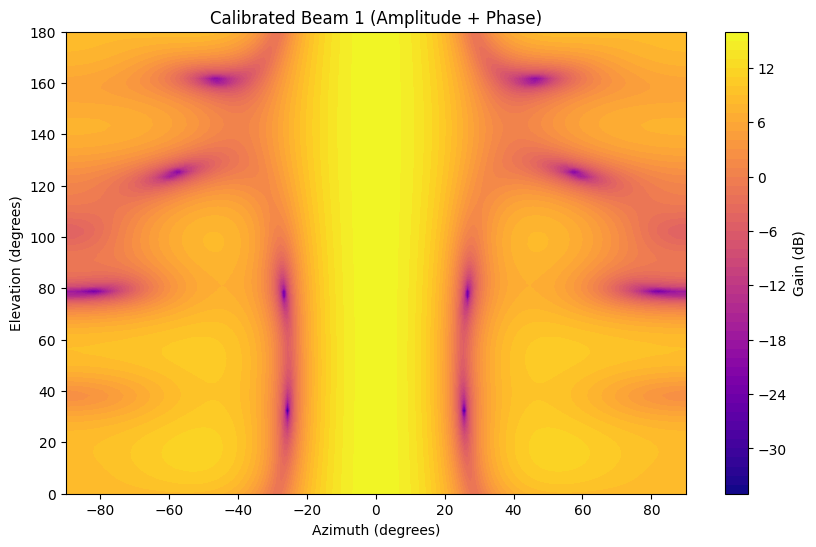

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm

# Load data (first 16 columns = TX weights)
def load_beam_codebook(file_path):
    df = pd.read_csv(file_path, header=None)
    return df.iloc[:, :16].values.astype(str)  # Use first 16 columns

# Convert hex to complex weights (amplitude + phase)
def hex_to_complex(hex_str):
    val = int(hex_str, 16)          # Hex to integer (0-63)
    phase = (val >> 4) / 8 * 2 * np.pi  # Upper 3 bits → phase [0, 2π]
    amp = (val & 0x7) / 8           # Lower 3 bits → amplitude [0, 1]
    return amp * np.exp(1j * phase)  # Complex weight

# Simulate beam pattern for a 4x4 planar array
def simulate_beam_pattern_2d(weights, freq=60e9):
    wavelength = 3e8 / freq
    spacing = wavelength / 2
    theta = np.linspace(-np.pi/2, np.pi/2, 180)  # Azimuth
    phi = np.linspace(0, np.pi, 90)              # Elevation
    theta_grid, phi_grid = np.meshgrid(theta, phi)
    
    # 4x4 array positions
    x = np.arange(4) * spacing
    y = np.arange(4) * spacing
    xx, yy = np.meshgrid(x, y)
    positions = np.vstack([xx.ravel(), yy.ravel()]).T
    
    # Reshape weights to 4x4 complex array
    assert len(weights) == 16, f"Expected 16 weights, got {len(weights)}"
    weights_2d = np.reshape([hex_to_complex(w) for w in weights], (4, 4))
    
    # Array response
    beam_pattern = np.zeros_like(theta_grid)
    for i, t in enumerate(theta):
        for j, p in enumerate(phi):
            wave_vector = 2 * np.pi * np.array([np.sin(t) * np.cos(p), 
                                              np.sin(t) * np.sin(p)]) / wavelength
            phase_delays = np.exp(1j * (positions @ wave_vector))
            weighted_response = phase_delays * weights_2d.ravel()
            beam_pattern[j, i] = np.abs(np.sum(weighted_response))
    
    return np.degrees(theta_grid), np.degrees(phi_grid), beam_pattern

# Plot beam pattern
def plot_beam_2d(theta, phi, pattern, title):
    plt.figure(figsize=(10, 6))
    plt.contourf(theta, phi, 20 * np.log10(pattern + 1e-10), levels=50, cmap=cm.plasma)
    plt.colorbar(label="Gain (dB)")
    plt.title(title)
    plt.xlabel("Azimuth (degrees)")
    plt.ylabel("Elevation (degrees)")
    plt.show()

# Load and plot
beam_weights_ideal = load_beam_codebook("Antenna_beambook_ideal.csv")
beam_weights_calib = load_beam_codebook("Antenna_beambook.csv")

beam_idx = 1  # Beam index (0 to 63)
theta, phi, pattern_ideal = simulate_beam_pattern_2d(beam_weights_ideal[beam_idx])
plot_beam_2d(theta, phi, pattern_ideal, f"Ideal Beam {beam_idx} (Amplitude + Phase)")

theta, phi, pattern_calib = simulate_beam_pattern_2d(beam_weights_calib[beam_idx])
plot_beam_2d(theta, phi, pattern_calib, f"Calibrated Beam {beam_idx} (Amplitude + Phase)")

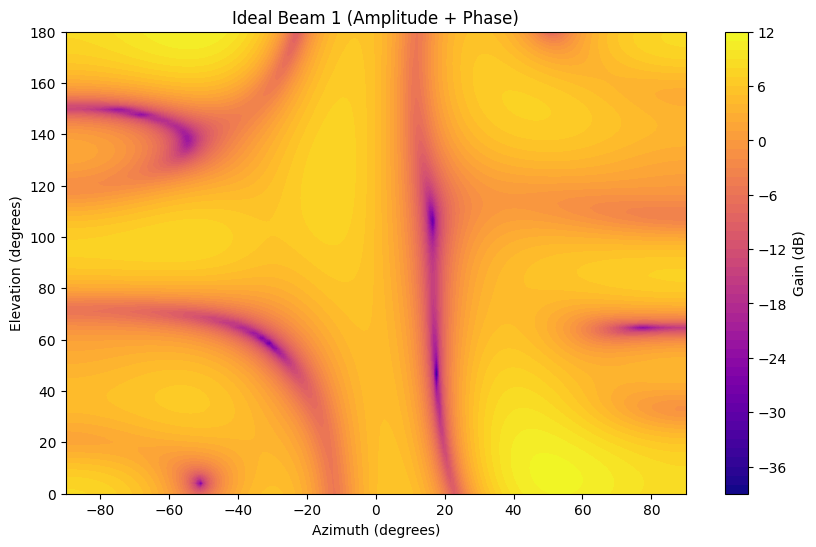

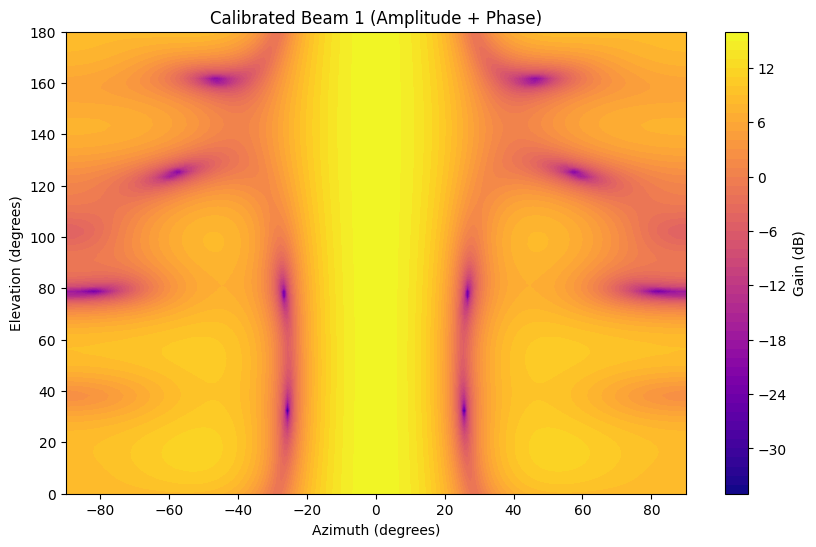

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm

# Load data (first 16 columns = TX weights)
def load_beam_codebook(file_path):
    df = pd.read_csv(file_path, header=None)
    return df.iloc[:, :16].values.astype(str)  # Use first 16 columns

# Convert hex to complex weights (amplitude + phase)
def hex_to_complex(hex_str):
    val = int(hex_str, 16)          # Hex to integer (0-63)
    phase = (val >> 3) / 8 * 2 * np.pi  # Upper 3 bits → phase [0, 2π]
    amp = (val & 0x7) / 8           # Lower 3 bits → amplitude [0, 1]
    return amp * np.exp(1j * phase)  # Complex weight

# Simulate beam pattern for a 4x4 planar array
def simulate_beam_pattern_2d(weights, freq=60e9):
    wavelength = 3e8 / freq
    spacing = wavelength / 2
    theta = np.linspace(-np.pi/2, np.pi/2, 180)  # Azimuth
    phi = np.linspace(0, np.pi, 90)              # Elevation
    theta_grid, phi_grid = np.meshgrid(theta, phi)
    
    # 4x4 array positions
    x = np.arange(4) * spacing
    y = np.arange(4) * spacing
    xx, yy = np.meshgrid(x, y)
    positions = np.vstack([xx.ravel(), yy.ravel()]).T
    
    # Reshape weights to 4x4 complex array
    assert len(weights) == 16, f"Expected 16 weights, got {len(weights)}"
    weights_2d = np.reshape([hex_to_complex(w) for w in weights], (4, 4))
    
    # Array response
    beam_pattern = np.zeros_like(theta_grid)
    for i, t in enumerate(theta):
        for j, p in enumerate(phi):
            wave_vector = 2 * np.pi * np.array([np.sin(t) * np.cos(p), 
                                              np.sin(t) * np.sin(p)]) / wavelength
            phase_delays = np.exp(1j * (positions @ wave_vector))
            weighted_response = phase_delays * weights_2d.ravel()
            beam_pattern[j, i] = np.abs(np.sum(weighted_response))
    
    return np.degrees(theta_grid), np.degrees(phi_grid), beam_pattern

# Plot beam pattern
def plot_beam_2d(theta, phi, pattern, title):
    plt.figure(figsize=(10, 6))
    plt.contourf(theta, phi, 20 * np.log10(pattern + 1e-10), levels=50, cmap=cm.plasma)
    plt.colorbar(label="Gain (dB)")
    plt.title(title)
    plt.xlabel("Azimuth (degrees)")
    plt.ylabel("Elevation (degrees)")
    plt.show()

# Load and plot
beam_weights_ideal = load_beam_codebook("Antenna_beambook_ideal.csv")
beam_weights_calib = load_beam_codebook("Antenna_beambook.csv")

beam_idx = 1  # Beam index (0 to 63)
theta, phi, pattern_ideal = simulate_beam_pattern_2d(beam_weights_ideal[beam_idx])
plot_beam_2d(theta, phi, pattern_ideal, f"Ideal Beam {beam_idx} (Amplitude + Phase)")

theta, phi, pattern_calib = simulate_beam_pattern_2d(beam_weights_calib[beam_idx])
plot_beam_2d(theta, phi, pattern_calib, f"Calibrated Beam {beam_idx} (Amplitude + Phase)")